# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# create X data from 2 gaussians
def random_gauss(sigma: float, mu: float, shape=(1, 25)) -> np.ndarray:
    return sigma*np.random.randn(*shape)+mu

params = [{"sigma": 2, "mu": 10}, {"sigma": 1.0, "mu": 0}]
gaussians = [random_gauss(**p) for p in params]
X = np.array(gaussians).reshape(1, -1)

def plot_data(X: np.ndarray, data_kwargs={"c": "steelblue", "alpha": 0.2, "label": "data point"}):
    plt.scatter(X, np.zeros_like(X), **data_kwargs)
    x_min, x_max = plt.xlim()
    space = 2
    plt.xlim((x_min-space, x_max+space))
    plt.grid()

def plot_kde(kde_func, num_points=20, range=None, pdf_kwargs={"c": "red", "label": "pdf"}, domain=None):
    if range is not None:
        space_to_show_pdf = range
        plt.ylim(space_to_show_pdf)
    start, stop = plt.xlim() if domain is None else domain
    pltX = np.linspace(start, stop, num_points)
    pltY = kde_func(pltX)

    plt.plot(pltX, pltY, **pdf_kwargs)

# plot the data in a window where y is from 0 to 1.0 and X can autoscale
def plot(X, kde_func=None, num_points=0, range=None, pdf_kwargs={"c": "red", "label": "pdf"}):
    plot_data(X)
    if num_points > 0:
        plot_kde(kde_func, num_points, range, pdf_kwargs)
    plt.legend()

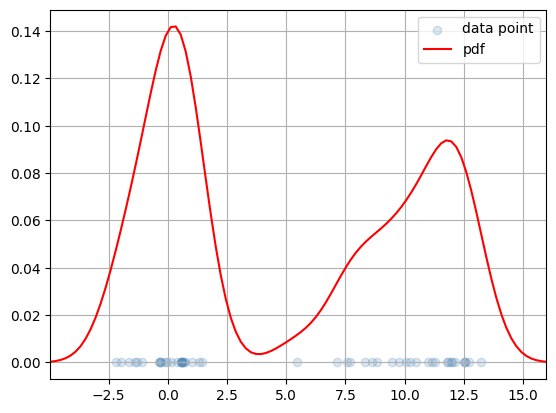

In [3]:
def gaussian_pdf(sigma, mu):
    sigma_squared = sigma**2
    exponent = lambda x: (-1/2) * ( (x-mu)**2 / sigma_squared )
    coeffecient = 1 / (np.sqrt(2*np.pi*sigma_squared))

    def pdf(X):
        return coeffecient*np.exp(exponent(X))

    return pdf

def KDE(X: np.ndarray, sigma=1.0):
    # go through X and create pdfs at mu = X_i and sigma is a hyperparam
    (m, n) = X.shape
    assert(m == 1 and n > 0)
    gaussian_pdfs = [gaussian_pdf(sigma, mu=X_i) for X_i in X[0]]

    def KDE_pdf(X):
        output = np.zeros_like(X)
        for pdf in gaussian_pdfs:
            output += pdf(X)
        return (1/n)*output

    return KDE_pdf

pdf = KDE(X, sigma=1.0)
plot(X, pdf, num_points=100)

In [4]:
def show_kde_results(X, num_points):
    def show(sigma):
        pdf = KDE(X, sigma)
        plot(X, pdf, num_points)
    return show

In [5]:
def create_bins(X: np.ndarray, num_bins=5, error=0.01):
    _min = X.min()
    _max = X.max()
    bin_size = (_max - _min) / num_bins

    bins = []
    curr = _min
    while curr <= _max:
        bins.append(curr)
        curr += bin_size

    # put some relaxation on the end
    bins[0] -= error
    bins[-1] += error

    return bins

def counts_given_bins(X: np.ndarray, bins):
    bin_counts = []
    for start, end in zip(bins, bins[1:]):
        bin_count = np.sum(np.logical_and((X >= start), (X <= end)).astype("int"))
        bin_counts.append(bin_count)

    return bin_counts

In [6]:
def hist(bins, counts):
    plt.hist(bins[:-1], bins, weights=counts, alpha=0.5, color="grey", label="frequency")

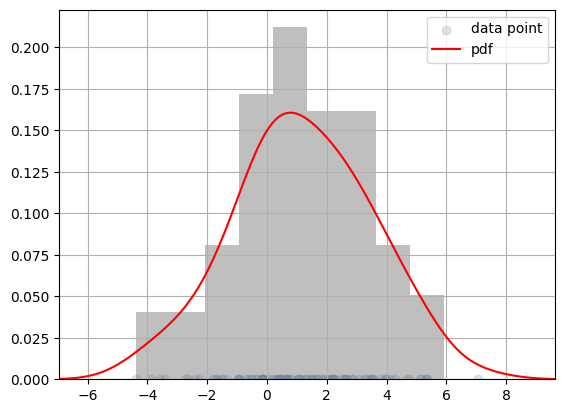

In [7]:
fraction = 100
X = (2*np.random.randn(1, fraction) + 1) + (np.random.randn(1, fraction) + 0.5)
pdf = KDE(X, sigma=1.0)
plot(X, pdf, 200)
bins = create_bins(X, num_bins=10)
counts = np.array(counts_given_bins(X, bins))
counts = counts / counts.sum()
hist(bins, counts)

# Experimentation

### Create Data to test from

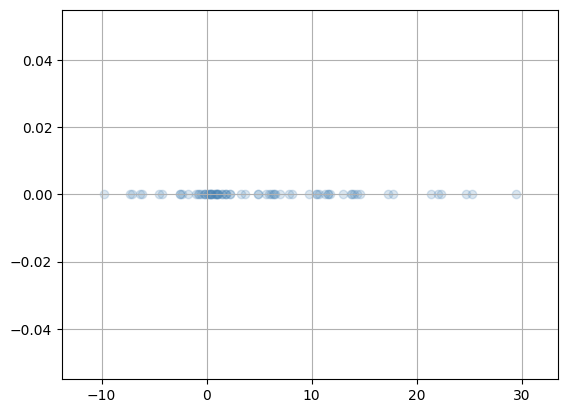

In [46]:
# fix numpy random seed
np.random.seed(0)
data = np.hstack((random_gauss(1.0, 0.0, shape=(1, 25)), random_gauss(10.0, 10.0, shape=(1,50))))
plot_data(data)

### Consider KDE on the data itself as the best solution

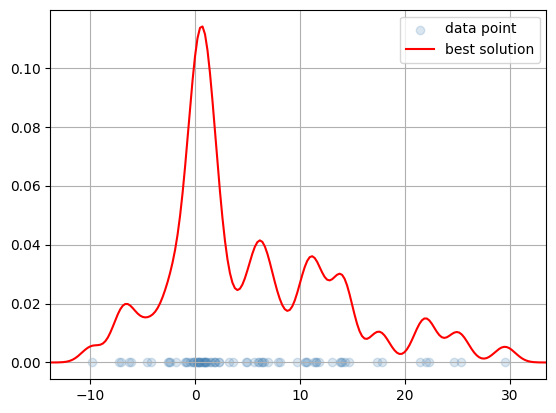

In [47]:
best_solution = KDE(data, sigma=1)
plot(data, best_solution, num_points=200, pdf_kwargs={"c": "red", "label": "best solution"})

### Compare KL divergence of best vs. bin summary

In [48]:
def kl_divergence(p, q):
	return np.sum(p*np.log(p/q))
def compare_kde(kde_func1, kde_func2, data, padding=3, points=200):
	X = np.linspace(int(data.min()-padding), int(data.max()+padding), points)
	return kl_divergence(kde_func1(X), kde_func2(X))

num bins is a parameter, but can assume as $n \rightarrow \infty$ the KL divergence will go to 0

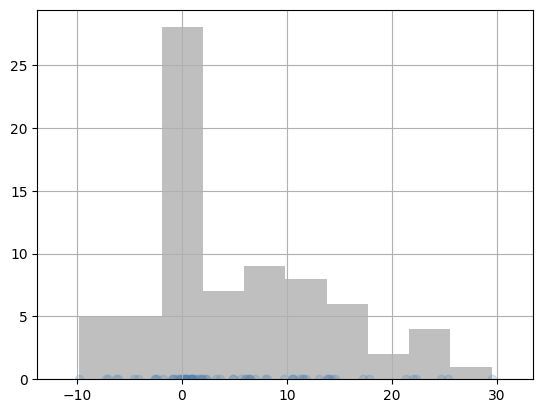

In [49]:
bins = np.array(create_bins(data, num_bins=10))
counts = np.array(counts_given_bins(data, bins))
hist(bins, counts)
plot_data(data)

1.9047592821894845

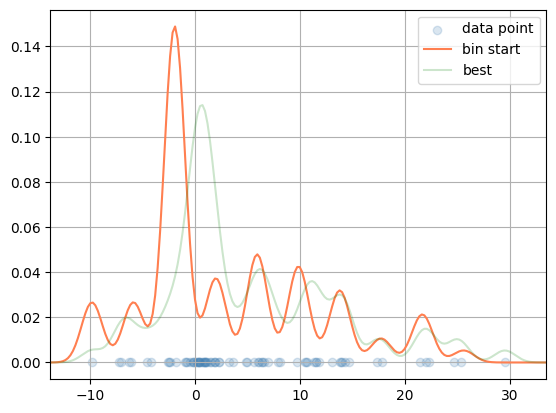

In [50]:
def naive_bin_KDE(bins: np.ndarray, counts: np.ndarray):
    # treat each bin as a that many gaussian's at start of bin edge
	fake_data = []
	for c, b in zip(counts.reshape(-1), bins.reshape(-1)):
		fake_data = [*fake_data, *[b]*c]

	fake_data = np.array(fake_data).reshape(1, -1)

	return KDE(fake_data)

naive_solution = naive_bin_KDE(bins, counts)
plot_data(data)
plot_kde(naive_solution, num_points=200, pdf_kwargs={"c": "coral", "label": "bin start"})
plot_kde(best_solution, num_points=200, pdf_kwargs={"c": "green", "label": "best", "alpha": 0.2})
plt.legend()

compare_kde(best_solution, naive_solution, data)

0.7908248745337465

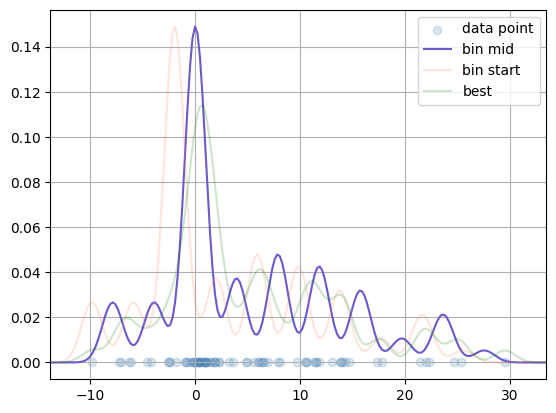

In [51]:
def naive_bin_KDE_mid(bins: np.ndarray, counts: np.ndarray, sigma=1):
    # treat each bin as a that many gaussian's in the middle of the bin
	fake_data = []
	shift = np.abs(bins[1] - bins[0]) / 2
	for c, b in zip(counts.reshape(-1), bins.reshape(-1)):
		fake_data = [*fake_data, *[b+shift]*c]

	fake_data = np.array(fake_data).reshape(1, -1)
	return KDE(fake_data, sigma)

naive_solution_mid = naive_bin_KDE_mid(bins, counts)
plot_data(data)
plot_kde(naive_solution_mid, num_points=200, pdf_kwargs={"c": "slateblue", "label": "bin mid"})
plot_kde(naive_solution, num_points=200, pdf_kwargs={"c": "coral", "label": "bin start", "alpha": 0.2})
plot_kde(best_solution, num_points=200, pdf_kwargs={"c": "green", "label": "best", "alpha": 0.2})
plt.legend()

compare_kde(best_solution, naive_solution_mid, data)

also recursive approximation

Say I look in each bin 10 times, I then evenly split the counts, then apply KDE to those. I use that function to guess where the densest region per bin is, then I use this in the total weighted kde.

/var/folders/lr/70kn5pjn69bdqbrtq53m3nch0000gn/T/ipykernel_1170/4120233489.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(p*np.log(p/q))
/var/folders/lr/70kn5pjn69bdqbrtq53m3nch0000gn/T/ipykernel_1170/4120233489.py:2: RuntimeWarning: overflow encountered in divide
  return np.sum(p*np.log(p/q))


bins 99
min kl divergence 0.020735038690870615


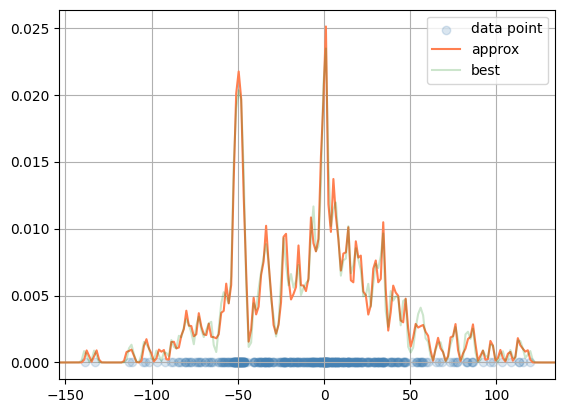

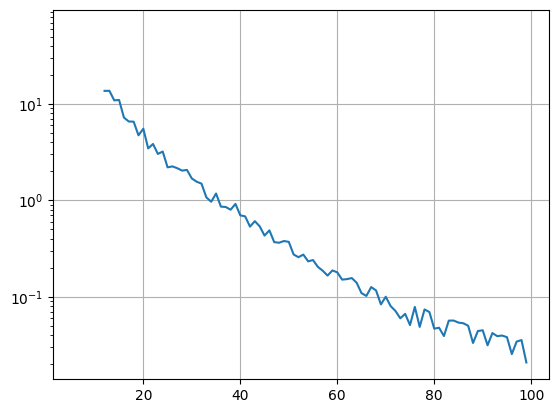

In [63]:
np.random.seed(0)
data = np.hstack( (random_gauss(1.0, 0.0, shape=(1, 25)), random_gauss(10.0, 10.0, shape=(1,50)), random_gauss(2, -50, shape=(1,50)), random_gauss(50.0, 0, shape=(1,300))))
best_solution = KDE(data)

smallest_kl_divergence = np.inf
argmin_kl_divergence = lambda x: x
argmin_bin_count = -1

kl_divergences = []
# over 200 bins is pushing it, hopefully can get reasonable results with less bins
bin_counts = [*list(range(2,100))]

for i in bin_counts:
	bins = np.array(create_bins(data, num_bins=i))
	counts = np.array(counts_given_bins(data, bins))
	naive_solution_mid = naive_bin_KDE_mid(bins, counts)
	kl = compare_kde(best_solution, naive_solution_mid, data)
	kl_divergences.append(kl)
	if kl < smallest_kl_divergence:
		smallest_kl_divergence = kl
		argmin_kl_divergence = naive_solution_mid
		argmin_bin_count = i


plot_data(data)
plot_kde(argmin_kl_divergence, num_points=200, pdf_kwargs={"c": "coral", "label": "approx"})
plot_kde(best_solution, num_points=200, pdf_kwargs={"c": "green", "label": "best", "alpha": 0.2})
plt.legend()
	
print("bins", argmin_bin_count)
print("min kl divergence", smallest_kl_divergence)

plt.show()
plt.yscale("log")
plt.plot(bin_counts, kl_divergences)
plt.grid()